In [1]:
import numpy as np
import pandas as pd
from pyirr import intraclass_correlation
pd.options.display.max_rows = 200
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy.stats import skew
sns.set_style('whitegrid')

In [2]:
# load data
df = pd.read_csv('/Users/morton/Dicom Files/RADSARC_R/XNAT/extractions/extractions__20221109_2030_allRegions/radiomicFeatures/radiomicFeatures.csv')
df.drop(list(df.filter(regex = 'source')), axis = 1, inplace = True)
df.drop(list(df.filter(regex = 'diagnostic')), axis = 1, inplace = True)

dfRep = pd.read_csv('/Users/morton/Dicom Files/RADSARC_R/XNAT/extractions/extractions__20221109_1137_repro/radiomicFeatures/radiomicFeatures.csv')
dfRep.drop(list(dfRep.filter(regex = 'source')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'diagnostic')), axis = 1, inplace = True)

# subjectIDs = df.merge(dfRep, on='StudyPatientName').StudyPatientName

# # select rows and make sure they are both sorted on SubjectID
# df = df.loc[df['StudyPatientName'].isin(subjectIDs)]
# df.sort_values('StudyPatientName', axis=0, inplace=True)

# dfRep = dfRep.loc[dfRep['StudyPatientName'].isin(subjectIDs)]
# dfRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove high/mid/low_enhancing features
df.drop(list(df.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
df.drop(list(df.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
df.drop(list(df.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
df.drop(list(df.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRep.drop(list(dfRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

df.reset_index(inplace=True)
dfRep.reset_index(inplace=True)

df = df.rename(columns=lambda x:x.replace('lesion_original_',''))
dfRep = dfRep.rename(columns=lambda x:x.replace('lesion_original_',''))

# keep copy with all patients for plots
dfMain = df.copy()

subjectIDs = df.merge(dfRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
df = df.loc[df['StudyPatientName'].isin(subjectIDs)]
df.sort_values('StudyPatientName', axis=0, inplace=True)

dfRep = dfRep.loc[dfRep['StudyPatientName'].isin(subjectIDs)]
dfRep.sort_values('StudyPatientName', axis=0, inplace=True)


In [3]:
iccValues = []
featNames = []
for col in df.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((df[col], dfRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

# display for feature with ICC under some threshold

iccThreshold = 0.75

iccDfgroup = iccDf.loc[iccDf['Feature'].str.contains('VolumeFraction'),:]

print('Group = ' + str('VolumeFraction').ljust(12) + ': # features with ICC > ' + str(iccThreshold) + ' = ' + str(np.sum(iccDfgroup.ICC>=iccThreshold)) + '/' + str(iccDfgroup.shape[0]))

iccDfgroup = iccDfgroup.sort_values('ICC', ascending=False)
display(iccDfgroup.style.hide_index())
print('\n\n\n')


for group in ['shape', 'firstorder']:
    iccDfgroup = iccDf[iccDf['Feature'].str.contains(group)]
    
    print('Group = ' + str(group).ljust(12) + ': # features with ICC > ' + str(iccThreshold) + ' = ' + str(np.sum(iccDfgroup.ICC>=iccThreshold)) + '/' + str(iccDfgroup.shape[0]))

    iccDfgroup = iccDfgroup.loc[iccDfgroup.ICC < iccThreshold, :]
    iccDfgroup.sort_values('ICC', ascending=False, inplace=True)
    display(iccDfgroup.style.hide_index())
    print('\n\n\n')
    
# do the same for all features except any in the groups listed (i.e. texture features)
iccDfgroup = copy.deepcopy(iccDf)
for group in ['VolumeFraction', 'shape', 'firstorder', 'histogram']:
    iccDfgroup = iccDfgroup.loc[~iccDfgroup.Feature.str.contains(group),:]
    
print('Group = ' + 'texture'.ljust(12) + ': # features with ICC > ' + str(iccThreshold) + ' = ' + str(np.sum(iccDfgroup.ICC>=iccThreshold)) + '/' + str(iccDfgroup.shape[0]))

iccDfgroup = iccDfgroup.loc[iccDfgroup.ICC < iccThreshold, :]
iccDfgroup.sort_values('ICC', ascending=False, inplace=True)
display(iccDfgroup.style.hide_index())


Group = VolumeFraction: # features with ICC > 0.75 = 4/4


Feature,ICC
lesion_sarcomaFeature_high enhancingVolumeFraction,0.999634
lesion_sarcomaFeature_calcificationVolumeFraction,0.999527
lesion_sarcomaFeature_low enhancingVolumeFraction,0.999387
lesion_sarcomaFeature_mid enhancingVolumeFraction,0.998163






Group = shape       : # features with ICC > 0.75 = 14/14


Feature,ICC






Group = firstorder  : # features with ICC > 0.75 = 17/18


Feature,ICC
firstorder_Minimum,0.558630






Group = texture     : # features with ICC > 0.75 = 54/73


Feature,ICC
glszm_SmallAreaLowGrayLevelEmphasis,0.709189
glrlm_ShortRunLowGrayLevelEmphasis,0.683499
gldm_LowGrayLevelEmphasis,0.625164
glrlm_LowGrayLevelRunEmphasis,0.610192
gldm_LargeDependenceLowGrayLevelEmphasis,0.572606
glszm_LowGrayLevelZoneEmphasis,0.540183
glrlm_LongRunHighGrayLevelEmphasis,0.527294
glrlm_LongRunLowGrayLevelEmphasis,0.434403
gldm_LargeDependenceHighGrayLevelEmphasis,0.418765
ngtdm_Busyness,0.414329


In [31]:
def featureClassDensities(featureClass, spSize):
    f,a = plt.subplots(spSize[0], spSize[1], figsize=(20,12))
    a = a.ravel()
    for n, feat in enumerate(dfMain.filter(regex = featureClass, axis = 1).columns):
        
        if skew(dfMain[feat])>3 and np.all(dfMain[feat]>0):
            dfHere = dfMain.copy()
            dfHere[feat] = np.log(dfHere[feat])
            sns.kdeplot(data=dfHere, x=feat, ax = a[n])
            a[n].text(0.98, 0.98, 'Log', bbox=dict(facecolor='red', alpha=0.5), horizontalalignment='right', verticalalignment='top', transform=a[n].transAxes)    
        else:
            sns.kdeplot(data=dfMain, x=feat, ax = a[n])

        skewStr = 'skew = ' + str(np.round(skew(dfMain[feat]),3))
        a[n].text(0.02, 0.98, skewStr, fontsize=14, horizontalalignment='left', verticalalignment='top', transform=a[n].transAxes)

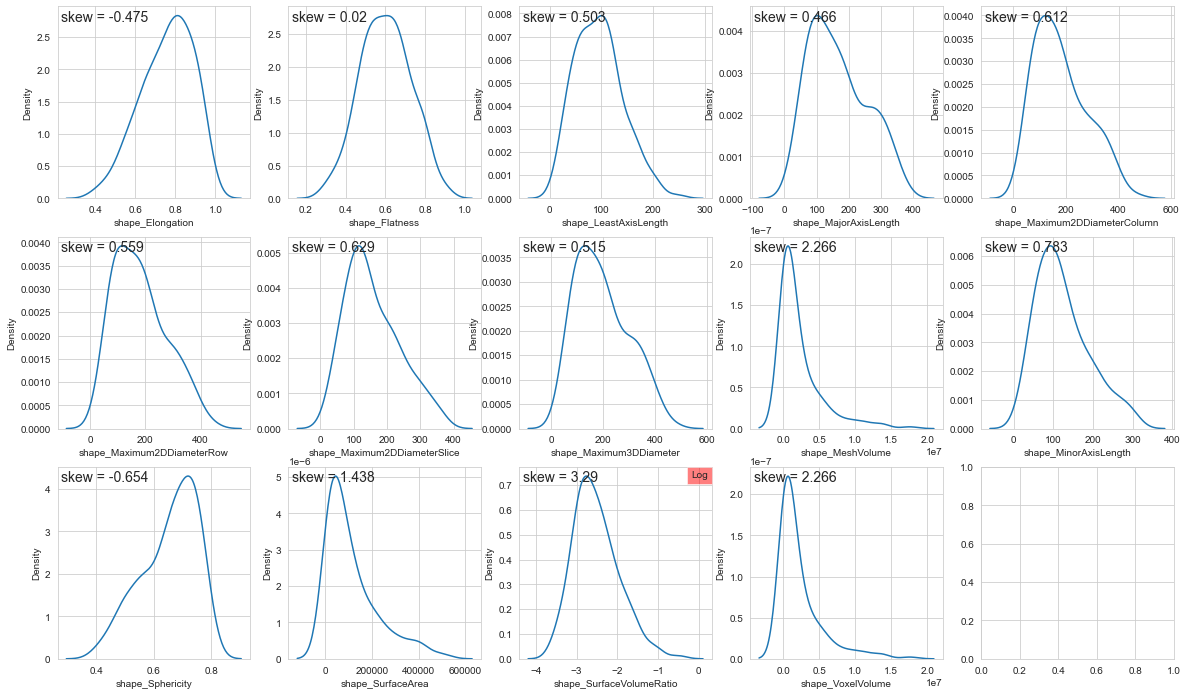

In [32]:
featureClassDensities('shape', (3, 5))

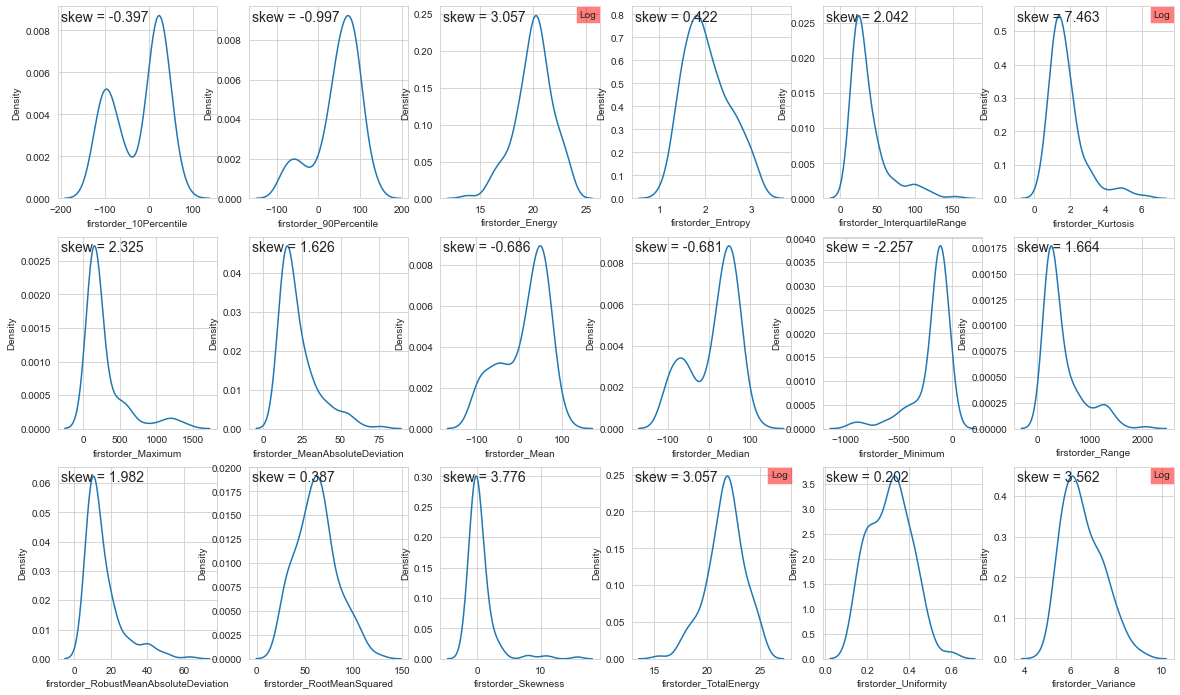

In [33]:
featureClassDensities('firstorder', (3, 6))

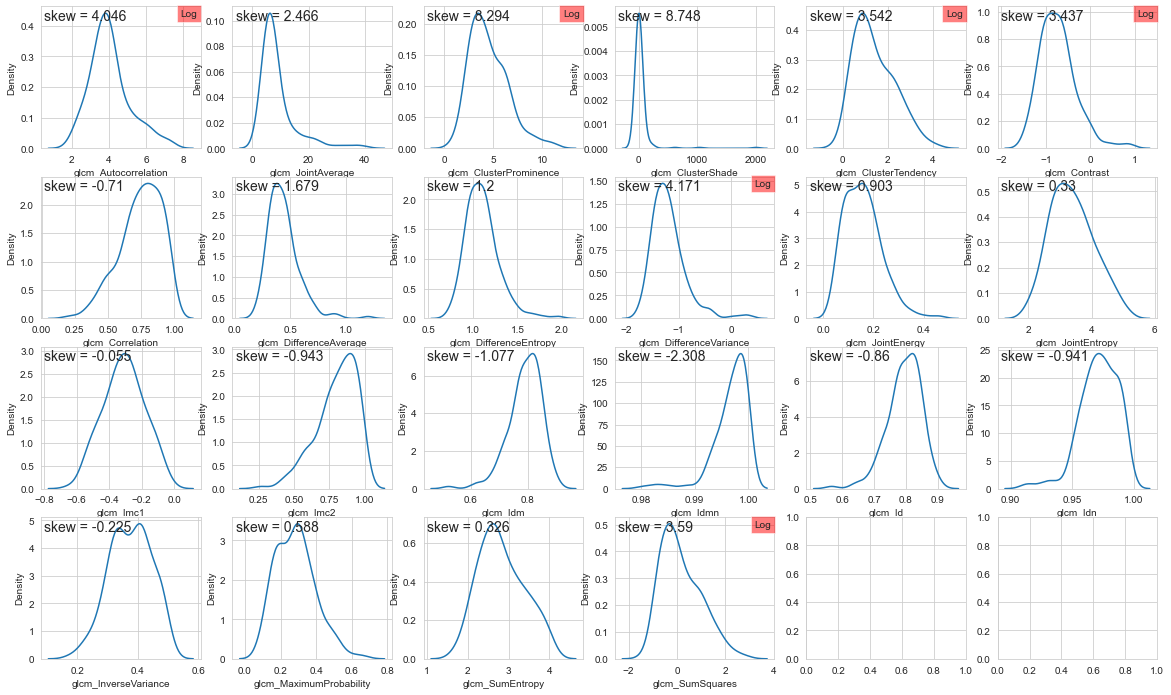

In [34]:
featureClassDensities('glcm', (4,6))
# featureClassDensities('glrlm', (4,4))
# featureClassDensities('glszm', (4,4))
# featureClassDensities('gldm', (3,5))
# featureClassDensities('ngtdm', (2,3))

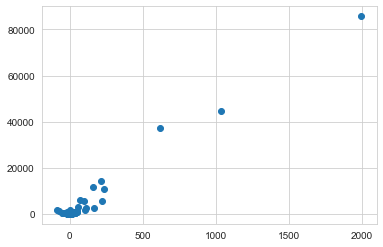

In [41]:
plt.plot(dfMain.filter(regex='ClusterShade'), dfMain.filter(regex='ClusterProminence'), marker='o', linestyle='none')

In [39]:
from scipy.stats import spearmanr

In [42]:
spearmanr(dfMain.filter(regex='Cluster')) #, dfMain.filter(regex='ClusterProminence'))

SpearmanrResult(correlation=array([[1.        , 0.30653086, 0.90185942],
       [0.30653086, 1.        , 0.19068398],
       [0.90185942, 0.19068398, 1.        ]]), pvalue=array([[0.00000000e+00, 4.79312287e-05, 3.97363283e-63],
       [4.79312287e-05, 0.00000000e+00, 1.27466826e-02],
       [3.97363283e-63, 1.27466826e-02, 0.00000000e+00]]))